In [ ]:
#!pip install pythainlp

     |████████████████████████████████| 11.0MB 4.1MB/s 
     |████████████████████████████████| 747kB 38.9MB/s 


In [ ]:
import re
import pandas as pd
import string
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.util import normalize
from pythainlp import word_vector
from fastai import *
from fastai.text import *
from fastai.basics import *
from pythainlp.tokenize import Tokenizer

pd.set_option('display.max_colwidth', 200)
pythainlp.__version__

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


100%|██████████| 62452646/62452646 [00:03<00:00, 20162340.91it/s]


'2.3.1'

In [ ]:
bangrak_df = pd.read_csv('./bangrak.csv')
beauty_df = pd.read_csv('./beauty.csv')
rajdumnern_df = pd.read_csv('./rajdumnern.csv')
religious_df = pd.read_csv('./religious.csv')
sinthorn_df = pd.read_csv('./sinthorn.csv')

In [ ]:
df = pd.concat([bangrak_df, beauty_df, rajdumnern_df, religious_df, sinthorn_df])

df.head()

Unnamed: 0  ...                                                                                                                                                                                                   detail
0           0  ...                                                                                                                                                                              \n   แก้ไขข้อความเมื่อ   \n
1           1  ...  \r\n\t\t\t\t\t\t\t\tแฟนเราชอบไปส่องผู้หญิง ไปเพิ่มเพื่อนผู้หญิงบ่อยมาก\nทั้งIG Facebook ชอบกดไลค์ กดอิโมจิ \nเวลาไปดูรายการที่มีเปิดวาร์ป ถ้าหญิงสวยก็จะไปส่องไปเพิ่มเพื่อนตลอด แฟนใครเป็นมั่งคะ แล้...
2           2  ...  \r\n\t\t\t\t\t\t\t\tพูดถึงสังคมในไทย \n-สาวประเภทสองเยอะมากและสวยมาก\n-เกย์ ไบ รสนิยมต่างๆก็เยอะมาก ออกสื่อก็เยอะ\n-ซีรี่วาย หนังวาย เลสเบี้ยน ออกสื่อโชเชี่ยว\n-มีการแต่งงานกันในเพศเดียวกัน\n-อื่น...
3           3  ...  \r\n\t\t\t\t\t\t\t\tเรามีแอบชอบพี่คนนึงเค้าโตกว่าเรา2ปี เรื่องของเราอาจเหมือนนิยายนะ แต่มันคือเรื่องจริง เริ่มจาก\nเราเริ่มชอบเค้าตอนม.1 ตอนนั้นเป็นค่าย เค้ามีให้เล่นเกม เราตกหลุมรักเพราะตอนเราจะล...
4           4  ...  \r\n\t\t\t\t\t\t\t\tตามกระทู้ ใครมีแฟนแบบนี้หรือมีโมเม้นต์อย่างนี้บ้าง\nใครที่ชอบให้แฟนสาวง้อ(ตัวเองผิดไม่เป็น)  ใครที่ต้องง้อแฟนชายบ่อยๆ\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t

[5 rows x 5 columns]

In [ ]:
df.shape

(25795, 5)

In [ ]:
def cleaner(text):  # make all texts lower case
  text = text.lower()
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"[^\u0E00-\u0E7Fa-zA-Z ]", "", text)
  text = re.sub(r"\n|\r|\t", " ", text)
  text = text.translate(str.maketrans("", "", string.punctuation))
  return normalize(text) # add normalize

In [ ]:
df['clean_detail'] = df['detail'].apply(cleaner)
df['clean_title'] = df['title'].apply(cleaner)
df.head()

Unnamed: 0  ...                                                         clean_title
0           0  ...                                                      หาเพื่อนคุยค่ะ
1           1  ...                                                 เราควรรู้สึกยังไงดี
2           2  ...            lgbtq ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที
3           3  ...                                                        รักข้างเดียว
4           4  ...  ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิงยิ่งกว่าอีกมั้ง

[5 rows x 7 columns]

In [ ]:
df.drop(df['clean_detail'] == "แก้ไขข้อความเมื่อ", errors="ignore")

Unnamed: 0  ...                                                                                              clean_title
2              2  ...                                                 lgbtq ในสังคมไทยทำไมยังไม่เปิดกว้างเหมือนต่างประเทศสักที
3              3  ...                                                                                             รักข้างเดียว
4              4  ...                                       ทำไมผู้ชายสมัยนี้งี่เง่าขี้น้อยใจทำตัวเหมือนผู้หญิงยิ่งกว่าอีกมั้ง
5              5  ...                                                                  ทำไมเวลาทะเลาะกับแฟน แฟนชอบคุยกับคนอื่น
6              6  ...                                                                                       วิธีลืมคนที่แอบชอบ
...          ...  ...                                                                                                      ...
5143        5143  ...                                                                       ราคายางพารา กลับขึ้นมาแล้วนะรู้ยัง
5144        5144  ...         set ต่อไปจะไม่ใช่กองและหรั่งเป็นฝ่ายคุมตลาด แต่รายย่อยจะคุมแทนเพราะดอกเบี้ยแบงค์ต่ำเตี้ยเรี่ยดิน
5145        5145  ...  หุ้นส่งออกไม้ ราคาไม้ คือ คอมโมนิดี้ที่แรงที่สุดในรอบเดือน และทำจุดสูงสุดตลอดกาลในรอบ ปี เร็วแรงติดจรวด
5146        5146  ...                                                   กู้สินเชื่อบ้าน ปกติกระบวนการเป็นยังไงคะ รอผลนานกี่วัน
5147        5147  ...                                                               เพิ่งหัดเทรด ดีใจจังเลยครับ ได้หุ้นฟรี trt

[25785 rows x 7 columns]

In [ ]:
vec_model = word_vector.get_model()
tokenizer = Tokenizer(custom_dict=vec_model.index2word, engine='newmm', keep_whitespace=False)

In [ ]:
def tokenize_word(text):
    tokenize_word = tokenizer.word_tokenize(text)
    tokenize_word = [w for w in tokenize_word  if w not in thai_stopwords() and w.strip() and w in vec_model.index2word] # ignore unknown words
    tokenize_word = list(map(lambda x: normalize(x), tokenize_word))
    return tokenize_word

In [ ]:
df['tokenize_word_detail'] = df['clean_detail'].apply(tokenize_word)
df['tokenize_word_title'] = df['clean_title'].apply(tokenize_word)

In [ ]:
### Create word vectors and indices for word embedding layer
word_idx = {}
word_vectors = []

w_idx = 0
## for titles
for line in df['tokenize_word_title']:
  for w in line:
    if w not in word_idx:
      word_idx[w] = w_idx
      word_vectors.append(vec_model[w])
      w_idx += 1

## for details (uncomment the following in case we will train with details)
"""
for line in df['tokenize_word_detail']:
  for w in line:
    if w not in word_idx:
      word_idx[w] = w_idx
      word_vectors.append(vec_model[w])
      w_idx += 1
"""
# append '' (blank) for padding
if '' not in word_idx:
  word_idx[''] = w_idx
  word_vectors.append(vec_model[''])

num_words = len(word_idx)
num_words

14194

In [ ]:
tokenize_word(df.iloc[0]['title'])

['หา', 'เพื่อน', 'คุย']

In [ ]:
df['title_count'] = df['tokenize_word_title'].apply(lambda x: len(x))
df

Unnamed: 0  ... title_count
0              0  ...           3
1              1  ...           2
2              2  ...           8
3              3  ...           2
4              4  ...           8
...          ...  ...         ...
5143        5143  ...           3
5144        5144  ...          15
5145        5145  ...          18
5146        5146  ...           7
5147        5147  ...           8

[25795 rows x 10 columns]

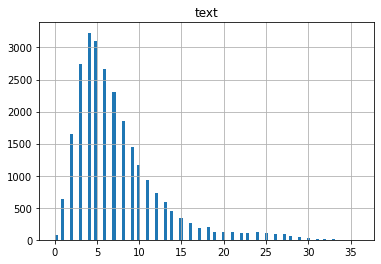

count    25795.000000
mean         7.371622
std          5.153011
min          0.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         36.000000
Name: title_count, dtype: float64


In [ ]:
#finding a suitable sequence length
# populate the list with length of the questions

length_df = pd.DataFrame({'text': df['title_count']})

length_df.hist(bins=100)
plt.show()
print(df['title_count'].describe())

In [ ]:
import ast
df['tags_list'] = df['tags'].apply(lambda x: ast.literal_eval(x))
print(df['tags_list'].head())
print(df.shape)

0                                                               [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                 [ประสบการณ์ความรัก]
2    [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                            [ความรักวัยรุ่น, แอบรัก]
4                                                                                                    [ความรักวัยรุ่น]
Name: tags_list, dtype: object
(25795, 9)


In [ ]:
freq= {}
for i in df['tags_list']:
  for j in i:
    if j in freq.keys():
      freq[j] = freq[j] + 1
    else:
      freq[j] = 1

In [ ]:
len(freq)

2334

In [ ]:
tag_freq = np.array(list(freq.values()))
print(tag_freq.mean())
print(tag_freq.std())


33.53427592116538
175.79246298393008


In [ ]:
freq = dict(sorted(freq.items(), key=lambda x:x[1], reverse=True))

In [ ]:
freq.items()

dict_items([('ปัญหาความรัก', 3347), ('การเมือง', 3225), ('หุ้น', 2713), ('ศาสนาพุทธ', 2622), ('ประสบการณ์ความรัก', 2233), ('ความงาม', 1842), ('รัฐบาล', 1702), ('ศาสนา', 1445), ('ประสบการณ์ชีวิตคู่', 1401), ('ความรักวัยรุ่น', 1362), ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250), ('ปฏิบัติธรรม', 1216), ('การลงทุน', 953), ('Skin Care', 945), ('ธนาคาร', 937), ('สิว', 929), ('พระไตรปิฎก', 910), ('ความรักวัยทำงาน', 896), ('การเงิน', 830), ('ศาลาคนเศร้า', 821), ('ลดความอ้วน', 759), ('ข่าวเศรษฐกิจ', 739), ('คลินิกความงาม', 728), ('วัด', 722), ('นักการเมือง', 703), ('ทำบุญ', 693), ('ศาลาคนโสด', 643), ('แอบรัก', 633), ('ศัลยกรรมความงาม', 626), ('แฟชั่น', 587), ('ปัญหาชีวิต', 537), ('เครื่องสำอาง', 534), ('ทำผม', 534), ('ตลาดหลักทรัพย์', 531), ('ปัญหาวัยรุ่น', 490), ('พิธีกรรมทางศาสนา', 450), ('Technical Analysis', 437), ('สุขภาพกาย', 428), ('ความรักต่างวัย', 417), ('มหาสติปัฏฐาน 4', 413), ('ออกกำลังกาย', 411), ('บัตรเครดิต', 411), ('การ์ตูนการเมือง', 410), ('อาหารเสริม', 408), ('

In [ ]:
list(freq.items())[:200]

[('ปัญหาความรัก', 3347),
 ('การเมือง', 3225),
 ('หุ้น', 2713),
 ('ศาสนาพุทธ', 2622),
 ('ประสบการณ์ความรัก', 2233),
 ('ความงาม', 1842),
 ('รัฐบาล', 1702),
 ('ศาสนา', 1445),
 ('ประสบการณ์ชีวิตคู่', 1401),
 ('ความรักวัยรุ่น', 1362),
 ('โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)', 1250),
 ('ปฏิบัติธรรม', 1216),
 ('การลงทุน', 953),
 ('Skin Care', 945),
 ('ธนาคาร', 937),
 ('สิว', 929),
 ('พระไตรปิฎก', 910),
 ('ความรักวัยทำงาน', 896),
 ('การเงิน', 830),
 ('ศาลาคนเศร้า', 821),
 ('ลดความอ้วน', 759),
 ('ข่าวเศรษฐกิจ', 739),
 ('คลินิกความงาม', 728),
 ('วัด', 722),
 ('นักการเมือง', 703),
 ('ทำบุญ', 693),
 ('ศาลาคนโสด', 643),
 ('แอบรัก', 633),
 ('ศัลยกรรมความงาม', 626),
 ('แฟชั่น', 587),
 ('ปัญหาชีวิต', 537),
 ('เครื่องสำอาง', 534),
 ('ทำผม', 534),
 ('ตลาดหลักทรัพย์', 531),
 ('ปัญหาวัยรุ่น', 490),
 ('พิธีกรรมทางศาสนา', 450),
 ('Technical Analysis', 437),
 ('สุขภาพกาย', 428),
 ('ความรักต่างวัย', 417),
 ('มหาสติปัฏฐาน 4', 413),
 ('ออกกำลังกาย', 411),
 ('บัตรเครดิต', 411),
 ('การ์ตูนการเมือง'

In [ ]:
common_tags = list(freq.keys())[:200]

In [ ]:
common_tags

['ปัญหาความรัก',
 'การเมือง',
 'หุ้น',
 'ศาสนาพุทธ',
 'ประสบการณ์ความรัก',
 'ความงาม',
 'รัฐบาล',
 'ศาสนา',
 'ประสบการณ์ชีวิตคู่',
 'ความรักวัยรุ่น',
 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)',
 'ปฏิบัติธรรม',
 'การลงทุน',
 'Skin Care',
 'ธนาคาร',
 'สิว',
 'พระไตรปิฎก',
 'ความรักวัยทำงาน',
 'การเงิน',
 'ศาลาคนเศร้า',
 'ลดความอ้วน',
 'ข่าวเศรษฐกิจ',
 'คลินิกความงาม',
 'วัด',
 'นักการเมือง',
 'ทำบุญ',
 'ศาลาคนโสด',
 'แอบรัก',
 'ศัลยกรรมความงาม',
 'แฟชั่น',
 'ปัญหาชีวิต',
 'เครื่องสำอาง',
 'ทำผม',
 'ตลาดหลักทรัพย์',
 'ปัญหาวัยรุ่น',
 'พิธีกรรมทางศาสนา',
 'Technical Analysis',
 'สุขภาพกาย',
 'ความรักต่างวัย',
 'มหาสติปัฏฐาน 4',
 'ออกกำลังกาย',
 'บัตรเครดิต',
 'การ์ตูนการเมือง',
 'อาหารเสริม',
 'รัฐศาสตร์',
 'ความเชื่อส่วนบุคคล',
 'ศาสนาอิสลาม',
 'ผลิตภัณฑ์ดูแลเส้นผม',
 'ชีวิตวัยรุ่น',
 'ศาสนาคริสต์',
 'TFEX (Thailand Future Exchange)',
 'กระทรวงสาธารณสุข',
 'พิธีกรรมและความเชื่อ',
 'Value Investment',
 'พรรคเพื่อไทย',
 'การเมืองต่างประเทศ',
 'ปัญหาครอบครัว',
 'ผลิตภัณฑ์ดูแลผิวห

In [ ]:
def common_tags_exis(tags_list):
    for tag in tags_list:
        if tag in common_tags:
            return True
    return False

In [ ]:
filter_common_df = df[df['tags_list'].apply(common_tags_exis)]
filter_common_df["common_tags"] = filter_common_df['tags_list'].apply(lambda x: list(filter(lambda x: x in common_tags, x)))
print(filter_common_df['common_tags'])
print(filter_common_df.shape)

0                                                                  [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                    [ประสบการณ์ความรัก]
2       [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                               [ความรักวัยรุ่น, แอบรัก]
4                                                                                                       [ความรักวัยรุ่น]
                                                              ...                                                       
5143                                                                                                              [หุ้น]
5144                                [หุ้น, บริษัทหลักทรัพย์, ตลาดหลักทรัพย์, กองทุนรวม, TFEX (Thailand Future Exchange)]
5145                            

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
y = mlb.fit_transform(filter_common_df['common_tags'])
y.shape

(25766, 200)

In [ ]:
y[0,:]

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [ ]:
filter_common_df['tags_list'].iloc[0:5]

0                                                               [ศาลาคนโสด, หาเพื่อน, ศาลาคนเศร้า, ประสบการณ์ความรัก]
1                                                                                                 [ประสบการณ์ความรัก]
2    [ความรักต่างวัย, ความรักวัยรุ่น, ความรักเพศที่สาม, กลุ่มบุคคลที่มีความหลากหลายทางเพศ (LGBT), ความหลากหลายทางเพศ]
3                                                                                            [ความรักวัยรุ่น, แอบรัก]
4                                                                                                    [ความรักวัยรุ่น]
Name: tags_list, dtype: object

In [ ]:
y[0:5,:]

array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]])

In [ ]:
print(mlb.classes_)

['Cardio' 'Dress Up Club' 'Fundamental Analysis' 'Hurt Room' ... 'โรคติดต่อ'
 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)' 'โรคผิวหนัง' 'โรงพยาบาล']


In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(filter_common_df['tokenize_word_title'], y, test_size=0.2, random_state=0, shuffle=True)
print(x_tr)
print(y_val)

4712                                                                                 [ตั้งกระทู้, เลือกตั้ง, ประธานาธิบดี, สหรัฐ, แบบนี้]
4346                                                                                 [แชมพู, ทอง, พัน, ช่าง, ผมหงอก, กลับมา, ดำ, รึเปล่า]
178                                                                                                    [สภาพ, จิตใจ, คนไทย, ยุค, โค, วิด]
3317    [cr, เพลง, รุ่งเรือง, ร่ำรวย, แต่ง, หลวงพ่อ, ช้าง, วัด, จุก, เฌอ, เมือง, แปด, ริ้ว, จังหวะ, สาม, ฟัง, สนุก, ข้อคิด, ลอง, ฟัง, ดู]
2007                                                                                               [มีเงิน, ลุง, ทุน, ธุรกิจ, บาท, ลงทุน]
                                                                      ...                                                                
2786                                                                  [ข่าว, ดี, ปู, เค็ม, แซะ, โฆษก, ไทย, อื้อ, ก่น, ก้น, กลายเป็น, ไร่]
4170                              

In [ ]:
#filter_common_df.to_csv("./filter_common.csv")

In [ ]:
from keras.preprocessing.sequence import pad_sequences 

max_len = 10

In [ ]:
num_words

14194

In [ ]:
import tensorflow as tf
tf.random.set_seed(0)
from keras.models import *
from keras.layers import *
from keras.callbacks import *
import keras.backend as k

In [ ]:
# custom texts to sequences
def texts_to_sequences(text_list):
  sequences = []
  for text in text_list:
    temp_list = []
    for word in text:
      temp_list.append(word_idx[word]) if word in word_idx else 0 # ignore unknown words
    sequences.append(temp_list)
  return sequences

In [ ]:
x_tr_seq = texts_to_sequences(x_tr)
x_val_seq = texts_to_sequences(x_val)

x_tr_seq = pad_sequences(x_tr_seq,  padding='post', maxlen=max_len, value=word_idx[''])
x_val_seq = pad_sequences(x_val_seq, padding='post', maxlen=max_len, value=word_idx[''])
print(x_tr_seq.shape)
print(x_val_seq.shape)
print(y_tr.shape)
print(y_val.shape)

(20612, 10)
(5154, 10)
(20612, 200)
(5154, 200)


In [ ]:
num_labels = y.shape[1]
num_labels

200

In [ ]:
def plot_model_loss(history, name):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Test')
    plt.legend(loc='upper right')
    plt.title(name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
def train_model(model, name):
    model.compile(optimizer='adam', loss='binary_crossentropy')
    mc = ModelCheckpoint(f"./{name}_thai2fit_best.hdf5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    his = model.fit(x_tr_seq, y_tr, batch_size=128, epochs=25, verbose=1, validation_data=(x_val_seq, y_val), callbacks=[mc])
    return his.history

In [ ]:
# define model architecture
k.clear_session()

#sequential model
lstm_model = Sequential()

#embedding layer
lstm_model.add(Embedding(num_words,
                    output_dim=300,
                    weights = [np.array(word_vectors)],
                    input_length=max_len,
                    mask_zero=False,
                    trainable=False))

#lstm 
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(128))

#dense layer
lstm_model.add(Dense(1024, activation='relu')) 
lstm_model.add(Dropout(0.5) )

#output layer
lstm_model.add(Dense(num_labels, activation='sigmoid'))

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           4258200   
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 4,946,528
Trainable params: 688,328
Non-trainable params: 4,258,200
________________________________________

In [ ]:
lstm_history = train_model(lstm_model, 'LSTM')

Epoch 1/25
162/162 [==============================] - 27s 17ms/step - loss: 0.1693 - val_loss: 0.0602

Epoch 00001: val_loss improved from inf to 0.06019, saving model to /gdrive/My Drive/DL_Project/LSTM_thai2fit_best.hdf5
Epoch 2/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0619 - val_loss: 0.0590

Epoch 00002: val_loss improved from 0.06019 to 0.05901, saving model to /gdrive/My Drive/DL_Project/LSTM_thai2fit_best.hdf5
Epoch 3/25
162/162 [==============================] - 1s 9ms/step - loss: 0.0589 - val_loss: 0.0539

Epoch 00003: val_loss improved from 0.05901 to 0.05387, saving model to /gdrive/My Drive/DL_Project/LSTM_thai2fit_best.hdf5
Epoch 4/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0544 - val_loss: 0.0520

Epoch 00004: val_loss improved from 0.05387 to 0.05198, saving model to /gdrive/My Drive/DL_Project/LSTM_thai2fit_best.hdf5
Epoch 5/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0516 - val_loss: 0.0493

E

In [ ]:
plot_model_loss(lstm_history, 'LSTM')

In [ ]:
lstm_model.load_weights("./LSTM_thai2fit_best.hdf5")
pred_prob = lstm_model.predict(x_val_seq)
pred_prob[0]

array([2.573272e-06, 6.099419e-05, 6.004628e-05, 5.665322e-04, ..., 1.025028e-03, 5.914305e-02, 2.485159e-05,
       1.699038e-04], dtype=float32)

In [ ]:
import scipy

In [ ]:
print(pred_prob.mean())
print(pred_prob.std())

0.01237792
0.05913104


In [ ]:
#define candidate threshold values
threshold  = np.arange(0,0.5,0.01)
threshold

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
       0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35,
       0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49])

In [ ]:
def classify(pred_prob, thresh):
  y_pred_seq = []

  for i in pred_prob:
    temp=[]
    for j in i:
      if j>=thresh:
        temp.append(1)
      else:
        temp.append(0)
    y_pred_seq.append(temp)

  return y_pred_seq

In [ ]:
from sklearn import metrics
def find_opt_threshold(y_val, threshold):
    score=[]
    #convert to 1 array
    y_true = np.array(y_val).ravel() 

    for thresh in threshold:
        
        #classes for each threshold
        y_pred_seq = classify(pred_prob, thresh) 

        #convert to 1d array
        y_pred = np.array(y_pred_seq).ravel()

        score.append(metrics.f1_score(y_true,y_pred))
    return threshold[score.index(max(score))]

In [ ]:
opt1 = find_opt_threshold(y_val, threshold)
opt1

0.22

In [ ]:
y_true = np.array(y_val).ravel() 

In [ ]:
y_pred_seq = classify(pred_prob, opt1)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [ ]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.42      0.44      0.43     13300

    accuracy                           0.99   1030800
   macro avg       0.71      0.71      0.71   1030800
weighted avg       0.99      0.99      0.99   1030800



In [ ]:
def get_prediction_dataframe(y_pred_seq, y_val):
    y_pred = mlb.inverse_transform(np.array(y_pred_seq))
    y_true = mlb.inverse_transform(np.array(y_val))

    prediction_df = pd.DataFrame({'comment':x_val,'actual':y_true,'predictions':y_pred})
    return prediction_df

In [ ]:
lstm_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)
lstm_prediction_df

comment  ...                                                                             predictions
3126  [jj, ny, โค, วิด, ฉุด, อสังหา, อี, อีซี, สารคดี, นางงาม, การเมือง, ฝีมือ, น้ำตาล, บอล, จี้, รัฐ, กล้า, กล้า, ทำ, ป้อม, เมิน, ตอบ, คนใน, รบ, เอี่ยว, บ่อน]  ...                                                                             (การเมือง,)
536                                                                                                                           [แม่ค้า, ออนไลน์, บ้าน, กู้, ไหม]  ...                                                     (ธนาคาร, สินเชื่อเพื่อที่อยู่อาศัย)
473                                                                                                                                   [พิม, รี่, ขอโทษ, ทักษิณ]  ...                                                                 (การเมือง, นักการเมือง)
349                                                                                                                 [กิน, อาหารเสริม, เลือด, จระเข้, mega, ไหม]  ...                                        (ลดความอ้วน, สุขภาพกาย, ออกกำลังกาย, อาหารเสริม)
3272                                                                                                                           [หุ่น, แบบนี้, ออกกำลังกาย, หรอ]  ...                                                      (ความงาม, ลดความอ้วน, ออกกำลังกาย)
...                                                                                                                                                         ...  ...                                                                                     ...
1023                                                                                                                                         [บวชเณร, โยม, ไหม]  ...                                                                      (ศาสนา, ศาสนาพุทธ)
3036                                                                                                                         [ทาน, งา, ดำ, ผม, กลับมา, เงา, ดำ]  ...                                                                                 (ทำผม,)
3697                                                                                                                         [ไม่มีใคร, เดต, ราคา, เหล็ก, เรือ]  ...                                                                                 (หุ้น,)
2256                                                                                                                       [แฟน, ชอบ, ไข่ดาว, ตอน, เฟ, ส, ไทม์]  ...  (ความรักวัยทำงาน, ความรักวัยรุ่น, ประสบการณ์ความรัก, ประสบการณ์ชีวิตคู่, ปัญหาความรัก)
3510                                                                                                                                                [งบ, aw, c]  ...                                                        (การลงทุน, ตลาดหลักทรัพย์, หุ้น)

[5154 rows x 3 columns]

In [ ]:
lstm_prediction_df.to_csv("./prediction-mix-lstm.csv")

In [ ]:
def predict_tag(model, comment, opt):  
  text=[]  
  text = [cleaner(comment)]
  text = [tokenize_word(comment)]
  seq = texts_to_sequences(text)
  pad_seq = pad_sequences(seq,  padding='post', maxlen=max_len, value=word_idx[''])
  pred_prob = model.predict(pad_seq)
  classes = classify(pred_prob,opt)[0]
  classes = np.array([classes])
  classes = mlb.inverse_transform(classes)  
  return classes

In [ ]:
comment = "รัฐบาลควบคุมโควิดไม่ได้เลย ทำยังไงดี"
print(predict_tag(lstm_model,comment, opt1))

[('การเมือง', 'รัฐบาล', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [ ]:
comment = "อยากหาร้านทำผม มีที่ไหนแนะนำบ้างครับ"
print(predict_tag(lstm_model,comment, opt1))

[('ทำผม', 'ผลิตภัณฑ์ดูแลเส้นผม', 'แฟชั่น')]


In [ ]:
comment = "การฉีดวัคซีนโควิด"
print(predict_tag(lstm_model,comment, opt1))

[('รัฐบาล', 'โรคติดเชื้อไวรัสโคโรนาสายพันธุ์ใหม่ 2019 (COVID-19)')]


In [ ]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(lstm_model,comment, opt1))

[('ความรักวัยทำงาน', 'ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ประสบการณ์ชีวิตคู่', 'ปัญหาความรัก')]


In [ ]:
comment = "เราท่านได้ดูโครงสร้างของ อานาปานสติ ได้ที่ไหน"
print(predict_tag(lstm_model,comment, opt1))

[('ปฏิบัติธรรม', 'พระไตรปิฎก', 'ศาสนา', 'ศาสนาพุทธ')]


In [ ]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(lstm_model,comment, opt1))

[('การลงทุน', 'ตลาดหลักทรัพย์', 'หุ้น')]


In [ ]:
comment = "ใครโสดยกมือหน่อยครับ อยากมีแฟนสักคน"
print(predict_tag(lstm_model,comment, opt1))

[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ประสบการณ์ชีวิตคู่', 'ปัญหาความรัก')]


In [ ]:
comment = "อยากลดความอ้วน แนะนำคลีนิคหน่อยครับ"
print(predict_tag(lstm_model,comment, opt1))

[('Skin Care', 'ความงาม', 'สิว')]


In [ ]:
print(predict_tag(lstm_model,comment, opt1))

[('Skin Care', 'ความงาม', 'สิว')]


In [ ]:
# GRU
# define model architecture
k.clear_session()

#sequential model
gru_model = Sequential()

#embedding layer
gru_model.add(Embedding(num_words,
                    output_dim=300,
                    weights = [np.array(word_vectors)],
                    input_length=max_len,
                    mask_zero=False,
                    trainable=False))

#lstm 
gru_model.add(GRU(128, return_sequences=True))
gru_model.add(GRU(128))

#dense layer
gru_model.add(Dense(1024, activation='relu')) 
gru_model.add(Dropout(0.5) )

#output layer
gru_model.add(Dense(num_labels,activation='sigmoid'))

In [ ]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 300)           4258200   
_________________________________________________________________
gru (GRU)                    (None, 10, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense (Dense)                (None, 1024)              132096    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               205000    
Total params: 4,859,488
Trainable params: 601,288
Non-trainable params: 4,258,200
________________________________________

In [ ]:
gru_history = train_model(gru_model, 'GRU')

Epoch 1/25
162/162 [==============================] - 8s 14ms/step - loss: 0.1625 - val_loss: 0.0599

Epoch 00001: val_loss improved from inf to 0.05986, saving model to /gdrive/My Drive/DL_Project/GRU_thai2fit_best.hdf5
Epoch 2/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0617 - val_loss: 0.0573

Epoch 00002: val_loss improved from 0.05986 to 0.05735, saving model to /gdrive/My Drive/DL_Project/GRU_thai2fit_best.hdf5
Epoch 3/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0572 - val_loss: 0.0528

Epoch 00003: val_loss improved from 0.05735 to 0.05278, saving model to /gdrive/My Drive/DL_Project/GRU_thai2fit_best.hdf5
Epoch 4/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0538 - val_loss: 0.0506

Epoch 00004: val_loss improved from 0.05278 to 0.05064, saving model to /gdrive/My Drive/DL_Project/GRU_thai2fit_best.hdf5
Epoch 5/25
162/162 [==============================] - 1s 8ms/step - loss: 0.0506 - val_loss: 0.0480

Epoch 

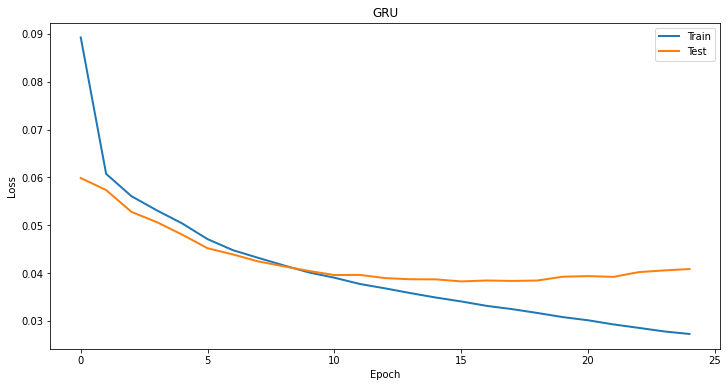

In [ ]:
plot_model_loss(gru_history, 'GRU')

In [ ]:
gru_model.load_weights("./GRU_thai2fit_best.hdf5")
pred_prob = gru_model.predict(x_val_seq)
pred_prob[0]

array([1.675685e-06, 1.002291e-05, 5.338635e-05, 2.434205e-04, ..., 6.400194e-03, 2.294860e-01, 6.757968e-05,
       1.959236e-04], dtype=float32)

In [ ]:
opt2 = find_opt_threshold(y_val, threshold)
opt2

0.25

In [ ]:
y_true = np.array(y_val).ravel() 

In [ ]:
y_pred_seq = classify(pred_prob, opt2)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [ ]:
print(metrics.classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.46      0.43      0.44     13300

    accuracy                           0.99   1030800
   macro avg       0.73      0.71      0.72   1030800
weighted avg       0.99      0.99      0.99   1030800



In [ ]:
gru_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)

In [ ]:
gru_prediction_df.to_csv("./prediction-mix-gru.csv")

In [ ]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(gru_model,comment, opt2))

[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ปัญหาความรัก')]


In [ ]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(gru_model,comment, opt2))

[('การลงทุน', 'การออมเงิน', 'การเงิน', 'ตลาดหลักทรัพย์', 'หุ้น')]


In [ ]:
# Simple RNN
# define model architecture
k.clear_session()

#sequential model
rnn_model = Sequential()

#embedding layer
rnn_model.add(Embedding(num_words,
                    output_dim=300,
                    weights = [np.array(word_vectors)],
                    input_length=max_len,
                    mask_zero=False,
                    trainable=False))

#lstm 
rnn_model.add(SimpleRNN(128, return_sequences=True))
rnn_model.add(SimpleRNN(128))

#dense layer
rnn_model.add(Dense(1024, activation='relu')) 
rnn_model.add(Dropout(0.5) )

#output layer
rnn_model.add(Dense(num_labels ,activation='sigmoid'))

In [ ]:
rnn_history = train_model(rnn_model, 'RNN')

Epoch 1/25
162/162 [==============================] - 14s 35ms/step - loss: 0.1426 - val_loss: 0.0600

Epoch 00001: val_loss improved from inf to 0.06002, saving model to /gdrive/My Drive/DL_Project/RNN_thai2fit_best.hdf5
Epoch 2/25
162/162 [==============================] - 5s 29ms/step - loss: 0.0618 - val_loss: 0.0590

Epoch 00002: val_loss improved from 0.06002 to 0.05900, saving model to /gdrive/My Drive/DL_Project/RNN_thai2fit_best.hdf5
Epoch 3/25
162/162 [==============================] - 5s 29ms/step - loss: 0.0603 - val_loss: 0.0573

Epoch 00003: val_loss improved from 0.05900 to 0.05727, saving model to /gdrive/My Drive/DL_Project/RNN_thai2fit_best.hdf5
Epoch 4/25
162/162 [==============================] - 5s 29ms/step - loss: 0.0583 - val_loss: 0.0560

Epoch 00004: val_loss improved from 0.05727 to 0.05604, saving model to /gdrive/My Drive/DL_Project/RNN_thai2fit_best.hdf5
Epoch 5/25
162/162 [==============================] - 5s 29ms/step - loss: 0.0556 - val_loss: 0.0526

E

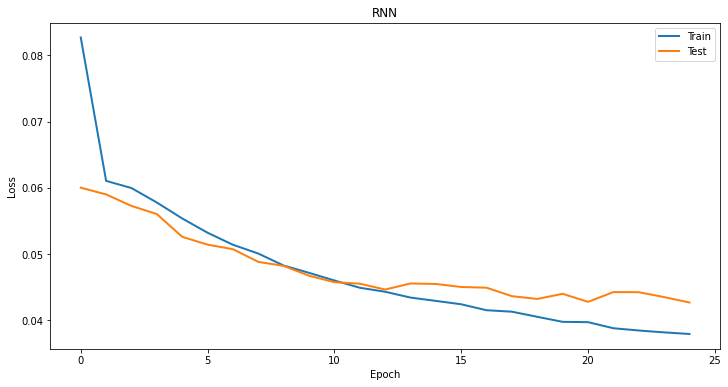

In [ ]:
plot_model_loss(rnn_history, 'RNN')

In [ ]:
rnn_model.load_weights("./RNN_thai2fit_best.hdf5")
pred_prob = rnn_model.predict(x_val_seq)
pred_prob[0]

array([3.509605e-07, 4.951210e-06, 4.461404e-06, 1.241453e-04, ..., 1.740760e-04, 1.247719e-01, 8.205755e-06,
       7.473233e-06], dtype=float32)

In [ ]:
y_true = np.array(y_val).ravel() 

In [ ]:
opt3 = find_opt_threshold(y_val, threshold)
opt3

0.21

In [ ]:
opt3 = 0.21

In [ ]:
y_pred_seq = classify(pred_prob, opt3)
y_pred = np.array(y_pred_seq).ravel()
y_pred

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [ ]:
print(metrics.classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1017500
           1       0.38      0.41      0.40     13300

    accuracy                           0.98   1030800
   macro avg       0.69      0.70      0.69   1030800
weighted avg       0.98      0.98      0.98   1030800



In [ ]:
rnn_prediction_df = get_prediction_dataframe(y_pred_seq, y_val)

In [ ]:
rnn_prediction_df.to_csv("./prediction-mix-rnn.csv")

In [ ]:
comment = "แอบรักผู้ชายข้างบ้าน ทำยังไงดี"
print(predict_tag(rnn_model,comment, opt3))

[('ความรักวัยรุ่น', 'ประสบการณ์ความรัก', 'ประสบการณ์ชีวิตคู่', 'ปัญหาความรัก', 'แอบรัก')]


In [ ]:
comment = "บิตคอยยังควรลงทุนไหม ช่วยชี้แนะหน่อยครับ"
print(predict_tag(rnn_model,comment, opt3))

[('การลงทุน', 'หุ้น')]


In [ ]:
comment = "ไปทำบุญที่ไหนดี"

print('LSTM using Thai2fit for embedding:', predict_tag(lstm_model,comment, opt1))
print('GRU using Thai2fit for embedding:', predict_tag(gru_model,comment, opt2))
print('RNN using Thai2fit for embedding:', predict_tag(rnn_model,comment, opt3))

LSTM using Thai2fit for embedding: [('ทำบุญ', 'ปฏิบัติธรรม', 'ศาสนา', 'ศาสนาพุทธ')]
GRU using Thai2fit for embedding: [('ทำบุญ', 'ปฏิบัติธรรม', 'ศาสนาพุทธ')]
RNN using Thai2fit for embedding: [('ปฏิบัติธรรม', 'พระไตรปิฎก', 'วัด', 'ศาสนา', 'ศาสนาพุทธ')]
